# Einstufung der Fragen nach Schwierigkeitsgrad

Dieses Notizbuch hat Copilot für einige der Code-Snippets verwendet, aber der Großteil des Inhalts ist selbst geschrieben.

In [8]:
import pandas as pd, re
import matplotlib.pyplot as plt
def load_excel_data(file_path: str) -> pd.DataFrame:
    """
    Lade eine Excel-Datei und gebe die Daten als DataFrame zurück.
    """
    return pd.read_excel(file_path, sheet_name="Questions")


In [ ]:
df = load_excel_data("../questions/questions.xlsx")
df = df[:-1] # Letzte Zeile ist reine Dateninfozeile

In [ ]:
# folgender Code wurde mit Hilfe von Copilot generiert
def features(sql):
    """
    Extrahiere verschiedene Merkmale aus einer SQL-Abfrage.
    """
    if not isinstance(sql, str):
        return {}
    s = re.sub(r"\s+", " ", sql.lower())
    return {
        "has_window": bool(re.search(r"\bover\s*\(", s) or re.search(r"\blag\s*\(", s) or re.search(r"\blead\s*\(", s)),
        "has_gapfill": "time_bucket_gapfill" in s,
        "has_time_bucket": "time_bucket(" in s,
        "has_stats_agg": "stats_agg(" in s or "timescaledb_experimental.stats_" in s,
        "has_regr_slope": "regr_slope(" in s or re.search(r"\bslope\s*\(", s),
        "join_count": len(re.findall(r"\bjoin\b", s)),
        "has_cte": s.strip().startswith("with "),
        "subquery_count": len(re.findall(r"\(\s*select\b", s)),
        "has_correlated_subq": bool(re.search(r"\bexists\s*\(\s*select\b", s) or re.search(r"\bin\s*\(\s*select\b", s)),
        "has_case": " case " in s,
        "has_group_by": " group by " in s,
        "has_having": " having " in s,
        "has_union": " union " in s,
        "uses_arrivals_or_departures": (" from arrivals" in s) or (" from departures" in s),
    }
def score(f):
    """
    Berechne einen Schwierigkeitswert basierend auf den extrahierten Merkmalen.
    """
    if not f: return 0
    sc = 0
    # heavy features
    if f["has_window"]: sc += 3
    if f["has_gapfill"]: sc += 3
    if f["has_stats_agg"]: sc += 3
    if f["has_regr_slope"]: sc += 3
    # joins
    if f["join_count"] >= 3: sc += 3
    elif f["join_count"] == 2: sc += 2
    elif f["join_count"] == 1: sc += 1
    # cte / having / union / correlated subq
    if f["has_cte"]: sc += 2
    if f["has_having"]: sc += 2
    if f["has_union"]: sc += 2
    if f["has_correlated_subq"]: sc += 2
    # subquery count (non-correlated)
    if not f["has_correlated_subq"]:
        if f["subquery_count"] >= 2: sc += 2
        elif f["subquery_count"] == 1: sc += 1
    # grouping / case / time_bucket
    if f["has_group_by"]: sc += 1
    if f["has_case"]: sc += 1
    if f["has_time_bucket"]: sc += 1  # base weight
    heavy_flags = any([f["has_window"], f["has_gapfill"], f["has_stats_agg"], f["has_regr_slope"],
                       f["join_count"] >= 2, f["has_cte"], f["has_having"],
                       f["has_correlated_subq"], f["has_union"]])
    if f["has_time_bucket"] and not heavy_flags:
        # if it's essentially a resampling/aggregation task without heavy ops, discount score
        sc -= 2
    
    # floor at zero
    return max(sc, 0)

In [23]:
feat_df = df["GoldenSQL"].apply(features).apply(pd.Series)
df_scored = df.join(feat_df)
df_scored["complexity_score"] = df_scored.apply(lambda r: score({k:r[k] for k in feat_df.columns}), axis=1)

In [27]:
# Verteilung der Scores in Bins: 1-6, 7-10, 11+
score_bin_edges = [-0.5, 5.5, 10.5, float("inf")]
score_bin_labels = ["leicht", "mittel", "schwer"]

df_scored["score_bin"] = pd.cut(
    df_scored["complexity_score"],
    bins=score_bin_edges,
    labels=score_bin_labels,
    include_lowest=True,
    right=True,
)
# Zusammenfassung und Plot
score_summary = (
    df_scored["score_bin"].value_counts().reindex(score_bin_labels, fill_value=0).reset_index()
)
score_summary.columns = ["difficulty", "count"]

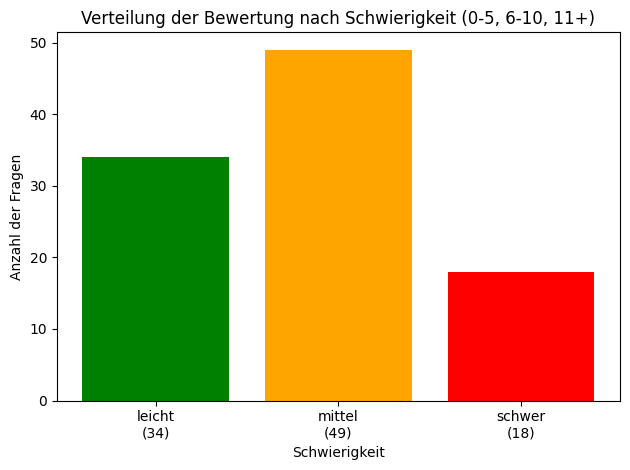

In [40]:
# Bar chart showing count of items per difficulty level
plt.figure()
plt.bar(score_summary["difficulty"], score_summary["count"], color=["green", "orange", "red"])
plt.xticks(score_summary["difficulty"], [f"{lbl}\n({cnt})" for lbl, cnt in zip(score_summary["difficulty"], score_summary["count"])])
plt.title("Verteilung der Bewertung nach Schwierigkeit (0-5, 6-10, 11+)")
plt.xlabel("Schwierigkeit")
plt.ylabel("Anzahl der Fragen")
plt.tight_layout()
plt.show()

In [ ]:
# save to questions_scored.xlsx
df_scored.to_excel("../questions/questions.xlsx", index=False)